# Backpropagation

In [1]:
# as discussed in the previous notebook,
# let's figure out the intermediate grads with our dummy expression (dL/df, dL/de, ..., dL/da)
# but for that, let us first update our Value class to hold and compute the grads

In [2]:
# updated micrograd Value class to compute and hold grads

class Value:
    """ stores a single scalar value and its gradient """

    def __init__(self, data, _children=(), _op='', label=''):
        self.data = data
        self.label = label  # optional, Value variable/node name
        self.grad = 0.0     # initially, the grad be zero (means no effect on output)

        # internal variables used for autograd graph construction
        self._prev = set(_children) # previous node
        self._op = _op              # the operation that produced this node

    def __repr__(self):
        return f"Value(data={self.data})"

    def __add__(self, other):
        out = Value(self.data + other.data, (self, other), '+')
        return out
    
    def __mul__(self, other):
        out = Value(self.data * other.data, (self, other), '*')
        return out


In [3]:
# updated visualization functions to show grads

from graphviz import Digraph

def trace(root):
    # builds a set of all nodes and edges in a graph
    nodes, edges = set(), set()
    def build(v):
        if v not in nodes:
            nodes.add(v)
            for child in v._prev:
                edges.add((child, v))
                build(child)
    build(root)
    return nodes, edges

def draw_dot(root, format='svg', rankdir='LR'):
    """
    format: png | svg | ...
    rankdir: TB (top to bottom graph) | LR (left to right)
    """
    assert rankdir in ['LR', 'TB']
    nodes, edges = trace(root)
    dot = Digraph(format=format, graph_attr={'rankdir': rankdir})
    
    for n in nodes:
        dot.node(name=str(id(n)), label = "{ %s | data: %.4f | grad: %.4f }" % (n.label, n.data, n.grad), shape='record')
        if n._op:
            dot.node(name=str(id(n)) + n._op, label=n._op)
            dot.edge(str(id(n)) + n._op, str(id(n)))
    
    for n1, n2 in edges:
        dot.edge(str(id(n1)), str(id(n2)) + n2._op)
    
    return dot

In [4]:
# Importing expression from the previous notebook
a = Value(2.0, label='a')
b = Value(-3.0, label='b')
c = a * b;  c.label='c'
d = Value(10.0, label='d')
e = c + d;  e.label='e'
f = Value(-2.0, label='f')
L = e * f;  L.label='L'
print(L) # L is loss function which we will try to minimize in backpropagation

Value(data=-8.0)


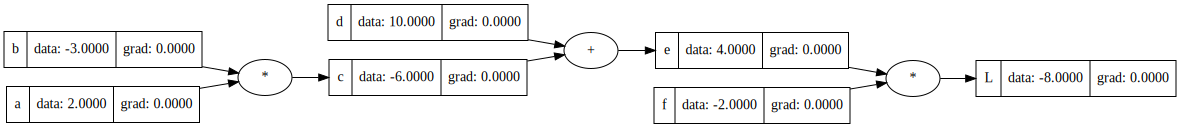

In [5]:
draw_dot(L)

In [6]:
# initially all the grads are zero (we assume the nodes have no effect on the output L, on initialization)
# let us now calculate and fill in the grads, by performing backpropagation manually